In [21]:
import pandas as pd
from datetime import datetime, timedelta

def pinrisk(ticker: str, folder: str = '.', extension: str = '.csv') -> pd.DataFrame:
    """
    Обрабатывает файл с 5-минутками по тикеру, возвращает DataFrame с уровнями T-90, T-60, T-30, T-5, Close.

    Параметры:
    - ticker: тикер инструмента
    - folder: путь к папке с файлами
    - extension: расширение

    Возвращает:
    - pandas.DataFrame с результатами по всем датам
    """

    #путь к файлу
    csv_path = f"{folder}/{ticker}{extension}"

    #CSV
    df = pd.read_csv(csv_path, sep=';')
    df.columns = [col.strip('<>').strip() for col in df.columns]

    # Создаём datetime
    df['datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format='%d.%m.%Y %H:%M:%S')
    df['date'] = df['datetime'].dt.date

    # Время закрытия (по NY time)
    close_time = datetime.strptime("16:00:00", "%H:%M:%S").time()
    time_offsets = {
        'T-90': -90,
        'T-60': -60,
        'T-30': -30,
        'T-5': -5,
        'Close': 0
    }

    # Сбор результатов
    results = []

    for date, group in df.groupby('date'):
        expiration_dt = datetime.combine(date, close_time)
        row = {'Дата': str(date), 'Тикер': ticker}
        for label, offset in time_offsets.items():
            target_time = expiration_dt + timedelta(minutes=offset)
            candle = group[group['datetime'] == target_time]

            if not candle.empty:
                row[label] = float(candle.iloc[0]['CLOSE'])
            else:
                row[label] = None
        row['DayMin'] = group['LOW'].min()
        row['DayMax'] = group['HIGH'].max() 
        results.append(row)

    return pd.DataFrame(results)


In [22]:
pinSPY=pinrisk('SPY')
pinQQQ=pinrisk('QQQ')
print(pinSPY)
print(pinQQQ)

          Дата Тикер    T-90     T-60     T-30     T-5   Close  DayMin  DayMax
0   2025-04-01   SPY  556.72  557.675  558.440  561.06  561.03  553.72  562.90
1   2025-04-02   SPY  561.11  561.110  563.180  565.13  564.65  554.85  567.40
2   2025-04-03   SPY  540.81  541.790  539.060  538.49  537.67  536.90  547.94
3   2025-04-04   SPY  508.84  507.760  510.570  506.59  505.50  505.07  525.85
4   2025-04-07   SPY  505.01  503.150  500.625  503.25  504.53  481.80  523.11
..         ...   ...     ...      ...      ...     ...     ...     ...     ...
79  2025-07-25   SPY  637.32  637.200  637.330  636.92  637.04  634.84  637.57
80  2025-07-28   SPY  636.03  636.070  636.040  636.59  636.92  635.54  638.02
81  2025-07-29   SPY  635.32  635.340  635.060  635.11  635.23  634.35  638.66
82  2025-07-30   SPY  636.77  632.890  632.070  633.43  634.48  631.56  637.67
83  2025-07-31   SPY  634.22  634.150  632.780  631.07  631.97  630.77  639.83

[84 rows x 9 columns]
          Дата Тикер    T-90 

In [24]:
# Исходный датафрейм (цены на ключевых точках)
df = pinrisk('SPY')

# Создаём отдельный датафрейм для изменений
df_changes = pd.DataFrame()

df_changes['Дата'] = df['Дата']
df_changes['Тикер'] = df['Тикер']

# изменения
df_changes['Δ_60_to_close'] = df['Close'] - df['T-60']
df_changes['Δ_30_to_close'] = df['Close'] - df['T-30']
df_changes['Δ_5_to_close']  = df['Close'] - df['T-5']

# изменения в процентах
df_changes['%Δ_60_to_close'] = (df_changes['Δ_60_to_close'] / df['T-60']) * 100
df_changes['%Δ_30_to_close'] = (df_changes['Δ_30_to_close'] / df['T-30']) * 100
df_changes['%Δ_5_to_close']  = (df_changes['Δ_5_to_close']  / df['T-5'])  * 100

# дневной диапазон
df_changes['DayRange'] = df['DayMax'] - df['DayMin']
df_changes['Δ_to_range_ratio'] = df_changes['Δ_60_to_close'] / df_changes['DayRange']





In [25]:
print(df_changes)


          Дата Тикер  Δ_60_to_close  Δ_30_to_close  Δ_5_to_close  \
0   2025-04-01   SPY          3.355          2.590         -0.03   
1   2025-04-02   SPY          3.540          1.470         -0.48   
2   2025-04-03   SPY         -4.120         -1.390         -0.82   
3   2025-04-04   SPY         -2.260         -5.070         -1.09   
4   2025-04-07   SPY          1.380          3.905          1.28   
..         ...   ...            ...            ...           ...   
79  2025-07-25   SPY         -0.160         -0.290          0.12   
80  2025-07-28   SPY          0.850          0.880          0.33   
81  2025-07-29   SPY         -0.110          0.170          0.12   
82  2025-07-30   SPY          1.590          2.410          1.05   
83  2025-07-31   SPY         -2.180         -0.810          0.90   

    %Δ_60_to_close  %Δ_30_to_close  %Δ_5_to_close  DayRange  Δ_to_range_ratio  
0         0.601605        0.463792      -0.005347      9.18          0.365468  
1         0.630892     

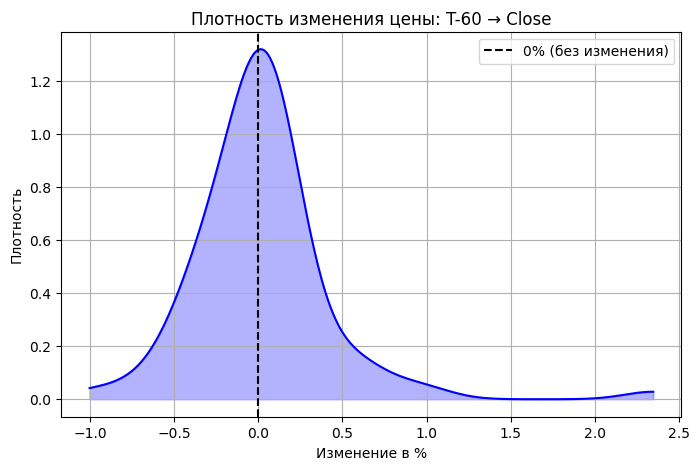

In [36]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Данные без пропусков
data = df_changes['%Δ_60_to_close'].dropna()

# Строим KDE
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 500)
y_vals = kde(x_vals)

# График
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, color='blue')
plt.fill_between(x_vals, y_vals, alpha=0.3, color='blue')

# Вертикальные линии
plt.axvline(0, color='black', linestyle='--', label='0% (без изменения)')

# Оформление
plt.title('Плотность изменения цены: T-60 → Close')
plt.xlabel('Изменение в %')
plt.ylabel('Плотность')
plt.grid(True)
plt.legend()
plt.show()


In [37]:
mode_index = np.argmax(y_vals)
typical_change = x_vals[mode_index]
print(f"Наиболее частое изменение: {typical_change:.3f}%")


Наиболее частое изменение: 0.018%


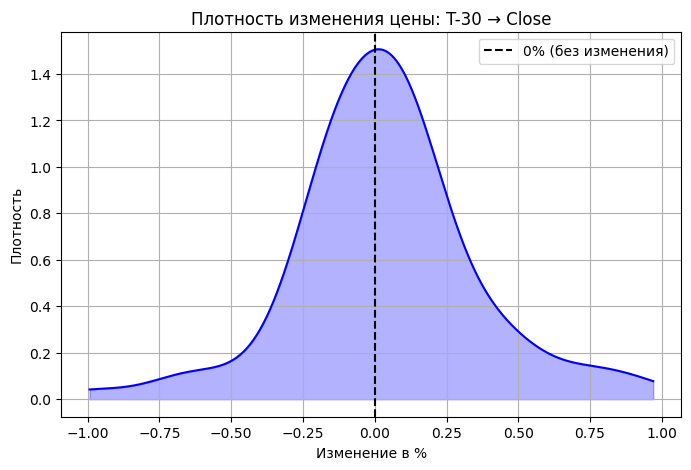

In [43]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Данные без пропусков
data = df_changes['%Δ_30_to_close'].dropna()

# Строим KDE
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 500)
y_vals = kde(x_vals)

# График
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, color='blue')
plt.fill_between(x_vals, y_vals, alpha=0.3, color='blue')

# Вертикальные линии
plt.axvline(0, color='black', linestyle='--', label='0% (без изменения)')

# Оформление
plt.title('Плотность изменения цены: T-30 → Close')
plt.xlabel('Изменение в %')
plt.ylabel('Плотность')
plt.grid(True)
plt.legend()
plt.show()


In [39]:
mode_index = np.argmax(y_vals)
typical_change = x_vals[mode_index]
print(f"Наиболее частое изменение: {typical_change:.3f}%")

Наиболее частое изменение: 0.014%


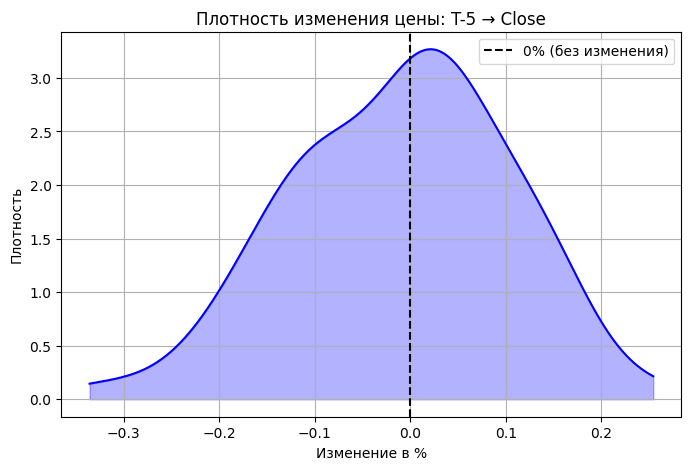

In [44]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Данные без пропусков
data = df_changes['%Δ_5_to_close'].dropna()

# Строим KDE
kde = gaussian_kde(data)
x_vals = np.linspace(data.min(), data.max(), 500)
y_vals = kde(x_vals)

# График
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, color='blue')
plt.fill_between(x_vals, y_vals, alpha=0.3, color='blue')

# Вертикальные линии
plt.axvline(0, color='black', linestyle='--', label='0% (без изменения)')

# Оформление
plt.title('Плотность изменения цены: T-5 → Close')
plt.xlabel('Изменение в %')
plt.ylabel('Плотность')
plt.grid(True)
plt.legend()
plt.show()

In [41]:
mode_index = np.argmax(y_vals)
typical_change = x_vals[mode_index]
print(f"Наиболее частое изменение: {typical_change:.3f}%")

Наиболее частое изменение: 0.021%


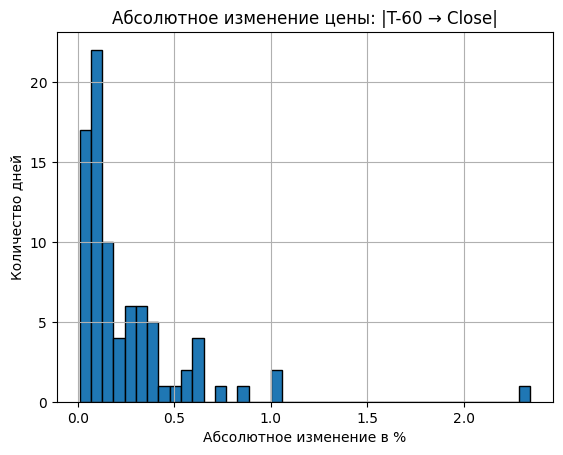

In [42]:
df_changes['abs_%Δ_60_to_close'] = df_changes['%Δ_60_to_close'].abs()

df_changes['abs_%Δ_60_to_close'].hist(bins=40, edgecolor='black')
plt.title('Абсолютное изменение цены: |T-60 → Close|')
plt.xlabel('Абсолютное изменение в %')
plt.ylabel('Количество дней')
plt.grid(True)
plt.show()
